## Imports

In [75]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from collections import defaultdict

import yfinance as yf
import ta
from sklearn.model_selection import train_test_split
import sklearn.metrics

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
from pytorch_lightning.callbacks import Callback, EarlyStopping, RichProgressBar, LearningRateMonitor

pl.seed_everything(1)

Global seed set to 1


1

## Dataset dowmload

In [76]:
def load_data():
    id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
    ticker_to_name_path = "Datasets/kaggle/Company.csv"

    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)
    tickers = company_name_df.ticker_symbol.tolist()

    market_data = yf.download((' ').join(tickers), start="2011-01-01", end="2020-01-03", group_by = 'ticker')

    returns = pd.DataFrame()
    for ticker in market_data.columns.levels[0]:
        returns[ticker] = market_data[ticker].Close.pct_change(1).dropna()

    # for ticker in market_data.columns.levels[0]:
    #     returns[ticker] = market_data[ticker].Close.shift(-1).dropna()

    market_data = market_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    market_data['Returns'] = None
    market_data['Returns'][:-6] = returns.values.flatten()
    # market_data = market_data.fillna(market_data.Returns.mean())
    market_data = market_data.dropna()
    market_data = market_data.reset_index()

    market_data.to_csv('Datasets/market/market.csv', index=False)

    return market_data

In [77]:
# load_data()

## Config dictionary with changed access

In [78]:
class AttributeDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config = {
    "batch_size" : 64,
    "data_dir" : "Datasets/market/market.csv",
    "num_workers" : 0,
    "scaler" : StandardScaler(),
    "ticker" : 'AAPL',
    "features" : ['Adj Close', 'Open', 'High', 'Low', 'Volume'],
    "target" : ['Returns'],
    "test_size" : 0.3,
    "val_size" : 0.8,
    "n_features" : 5,
    "n_hidden" : 128,
    "sequence_length" : 5,
    "n_layers" : 2,
    "dropout" : 0.2,
    "loss_function" : nn.MSELoss(),
    "learning_rate" : 1e-3,
    "scheduler" : torch.optim.lr_scheduler.ReduceLROnPlateau,
    "frequency" : 5,
    "monitor" : 'val_loss',
    "epochs" : 20,
    "optimizer" : torch.optim.Adam,
    "version": 0,
    "patience": 30
    }

config = AttributeDict(config)

## Pytorch Lightning dataset + DataModule

In [79]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.sequence_length = sequence_length
        
    def __len__(self):
        return self.X.__len__() - (self.sequence_length - 1)
  
    def __getitem__(self, idx):
        return (self.X[idx:idx + self.sequence_length], self.y[idx + self.sequence_length - 1])

In [80]:
class StockReturnsDataModule(pl.LightningDataModule):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.batch_size = self.config.batch_size
    self.data_dir = self.config.data_dir
    self.num_workers = self.config.num_workers
    self.scaler = self.config.scaler
    self.ticker = self.config.ticker
    self.features = self.config.features
    self.target = self.config.target
    self.test_size = self.config.test_size
    self.val_size = self.config.val_size


  def prepare_data(self):
    dataset = pd.read_csv(self.data_dir)
    
    try:
      self.dataset = dataset[dataset.Ticker == self.ticker]
    except Exception:
      dataset = load_data()
    self.dataset = dataset[dataset.Ticker == self.ticker]

  def setup(self, stage=None):

    self.dataset = ta.add_all_ta_features(
      self.dataset, "Open", "High", "Low", "Close",
      "Volume", fillna=True
    )

    X_train, X_test, y_train, y_test = train_test_split(
      self.dataset[self.features].values, self.dataset[self.target].values,
      test_size = self.test_size, shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(
      X_test, y_test, test_size = self.val_size, shuffle=False)

    self.X_train = self.scaler.fit_transform(X_train)
    self.y_train = y_train.reshape((-1, 1))

    self.X_test = self.scaler.transform(X_test)
    self.y_test = y_test.reshape((-1, 1))

    self.X_val = self.scaler.transform(X_val)
    self.y_val = y_val.reshape((-1, 1))
  
  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(
      self.X_train, self.y_train, self.config.sequence_length)

    return DataLoader(
        train_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers = self.num_workers
    )

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(
      self.X_test, self.y_test, self.config.sequence_length)

    return DataLoader(
        test_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers = self.num_workers
    )

  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(
      self.X_val, self.y_val, self.config.sequence_length)

    return DataLoader(
        val_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers = self.num_workers
    )

## Model

In [81]:
class LSTMRegressor(pl.LightningModule):
    def __init__(self, config):
        super(LSTMRegressor, self).__init__()
        self.save_hyperparameters(dict(config))
        self.config = config
        self.n_features = self.config.n_features
        self.n_hidden = self.config.n_hidden
        self.sequence_length = self.config.sequence_length
        self.batch_size = self.config.batch_size
        self.n_layers = self.config.n_layers
        self.dropout = self.config.dropout
        self.loss_function = self.config.loss_function
        self.learning_rate = self.config.learning_rate
        self.scheduler = self.config.scheduler
        self.optimizer = self.config.optimizer
        self.frequency = self.config.frequency
        self.monitor = self.config.monitor

        self.lstm = nn.LSTM(
            input_size = self.n_features, 
            hidden_size = self.n_hidden,
            num_layers = self.n_layers, 
            # dropout = self.dropout, 
            batch_first=True)
                            
        self.linear = nn.Linear(self.n_hidden, 1)

        # self.relu = nn.ReLU()
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # relu_out = self.relu(lstm_out)
        return self.linear(lstm_out[:,-1])


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_function(y, y_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        self._shared_eval(batch, batch_idx, "val")
    
    def test_step(self, batch, batch_idx):
        self._shared_eval(batch, batch_idx, "test")

    def _shared_eval(self, batch, batch_idx, prefix):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_function(y, y_hat)
        self.log(f"{prefix}_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)

        return optimizer

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

## Visualize functions

In [82]:
class MyPrintingCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training has started")

    def on_train_end(self, trainer, pl_module):
        print("Training has ended")

    def on_epoch_end(self, trainer, pl_module):
        pass

In [83]:
def plot_prediction(trainer, model, datamodule, type="val"):
    if type == "test":
        predictions = trainer.predict(model, datamodule.test_dataloader())
        true = [y for _, y in datamodule.test_dataloader()]
    elif type == "val":
        predictions = trainer.predict(model, datamodule.val_dataloader())
        true = [y for _, y in datamodule.val_dataloader()]
    elif type == "train":
        predictions = trainer.predict(model, datamodule.train_dataloader())
        true = [y for _, y in datamodule.train_dataloader()]

    true = torch.cat(true).cpu().detach().numpy()
    predictions = torch.cat(predictions).cpu().detach().numpy()

    plt.figure()
    plt.title(f'Stock returns on {type} data')
    plt.plot(true, label='true')
    plt.plot(predictions, label='predicted')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title(f'Stock returns on {type} data cumulative')
    plt.plot(true.cumsum(), label='true')
    plt.plot(predictions.cumsum(), label='predicted')
    plt.legend()
    plt.show()

def plot_loss(version):
    metrics = pd.read_csv(f'./lstm/{version}/metrics.csv')
    train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
    val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
    test_loss = metrics['test_loss'].iloc[-1]

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
    axes[0].set_title('Train loss per epoch')
    axes[0].plot(train_loss['epoch'], train_loss['train_loss'])
    axes[1].set_title('Validation loss per epoch')
    axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
    plt.show(block = True)

    print('MSE:')
    print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.6f}")
    print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.6f}")
    print(f'Test loss:  {test_loss:.6f}')

## Trainer

In [84]:
def setup_pl_trainer(config):
    csv_logger = pl.loggers.csv_logs.CSVLogger('./', name='lstm', version=str(config.version)),

    checkpoint_callback = ModelCheckpoint(save_last=True)

    trainer = pl.Trainer(
        max_epochs = config.epochs,
        logger = csv_logger,
        gpus = 1,
        log_every_n_steps=1,
        callbacks=[
            MyPrintingCallback(),
            EarlyStopping('val_loss', patience=config.patience),
            RichProgressBar(refresh_rate=0),
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch')
            ])
    return trainer

In [85]:
config.epochs = 300
config.ticker = 'AAPL'
config.version = 'AAPL'
config.dropout = 0.1
config.sequence_length = 10
config.batch_size = 512
config.learning_rate = 1e-5
config.test_size = 0.3
config.val_size = 0.7
config.patience = 30
config.n_hidden = 64
# config.features = ['Adj Close', 'trend_macd', 'momentum_rsi', 'volatility_atr']
config.features = ['Close', 'Open', 'High', 'Low', 'Volume']
config.n_features = len(config.features)

model = LSTMRegressor(config)

b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.
  rank_zero_warn(


In [86]:
print(model)

LSTMRegressor(
  (loss_function): MSELoss()
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [87]:
for item in list(model.parameters()):
    print(item.size())

torch.Size([256, 5])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


In [88]:
config

{'batch_size': 512,
 'data_dir': 'Datasets/market/market.csv',
 'num_workers': 0,
 'scaler': StandardScaler(),
 'ticker': 'AAPL',
 'features': ['Close', 'Open', 'High', 'Low', 'Volume'],
 'target': ['Returns'],
 'test_size': 0.3,
 'val_size': 0.7,
 'n_features': 5,
 'n_hidden': 64,
 'sequence_length': 10,
 'n_layers': 2,
 'dropout': 0.1,
 'loss_function': MSELoss(),
 'learning_rate': 1e-05,
 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'frequency': 5,
 'monitor': 'val_loss',
 'epochs': 300,
 'optimizer': torch.optim.adam.Adam,
 'version': 'AAPL',
 'patience': 30}

In [89]:
datamodule = StockReturnsDataModule(config)
datamodule.prepare_data()
datamodule.setup()
trainer = setup_pl_trainer(config)
trainer.fit(model, datamodule)
trainer.test(model, datamodule)

b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:785: RuntimeWar

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss_function │ MSELoss │      0 │
│ 1 │ lstm          │ LSTM    │ 51.5 K │
│ 2 │ linear        │ Linear  │     65 │
└───┴───────────────┴─────────┴────────┘

Trainable params: 51.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 51.5 K                                                                                               
Total estimated model params size (MB): 0

b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\loggers\csv_logs.py:57: UserWarning: Experiment logs directory ./lstm\AAPL exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Training has started
Training has ended


b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0001651077182032168   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0001651077182032168}]

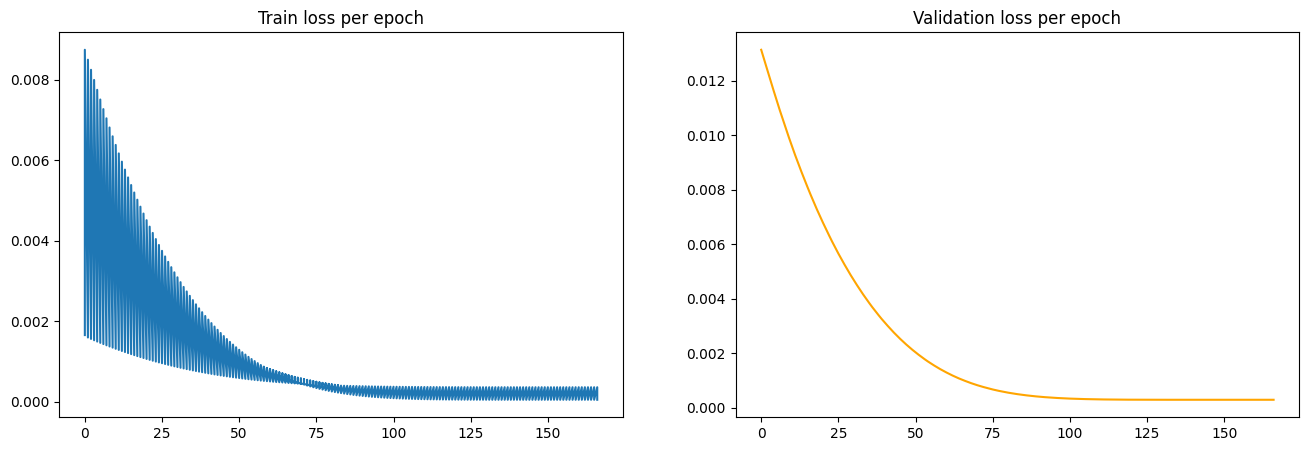

MSE:
Train loss: 0.000050
Val loss:   0.000299
Test loss:  0.000165


In [90]:
plot_loss(config.version)

b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


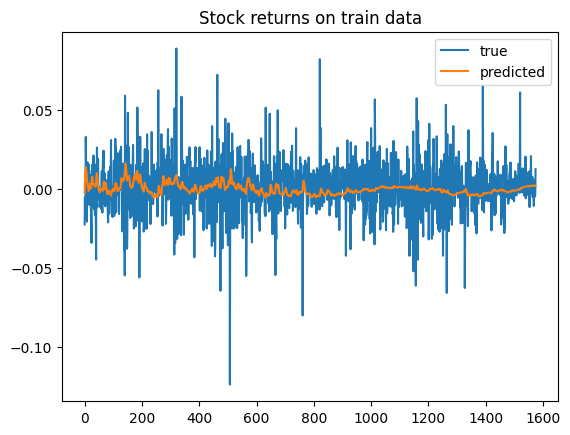

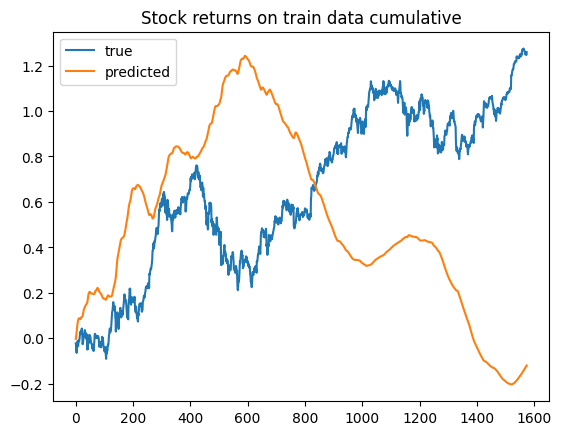

In [91]:
plot_prediction(trainer, model, datamodule, type="train")

b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


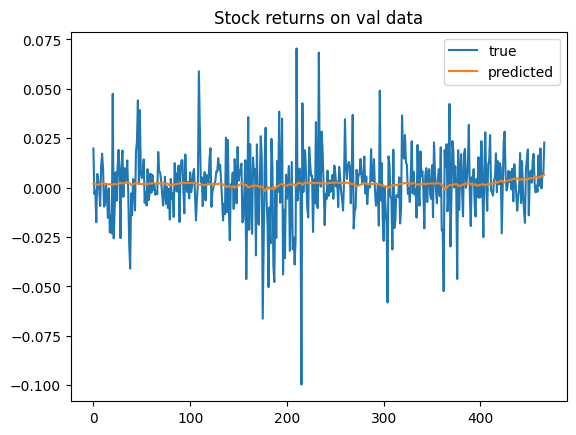

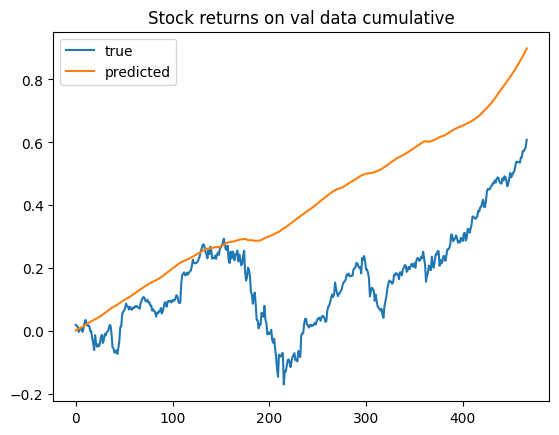

In [92]:
plot_prediction(trainer, model, datamodule, type="val")

b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
b:\HSE_Masters\.conda\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


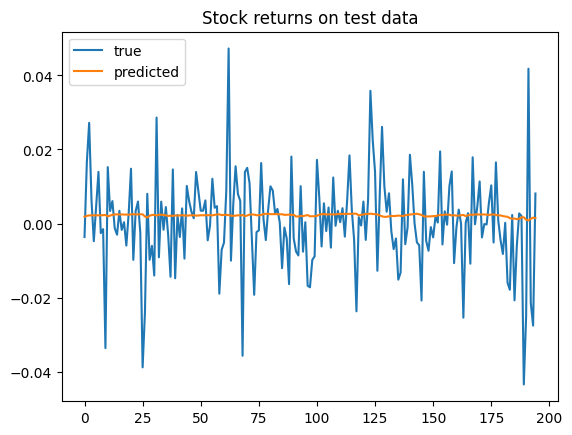

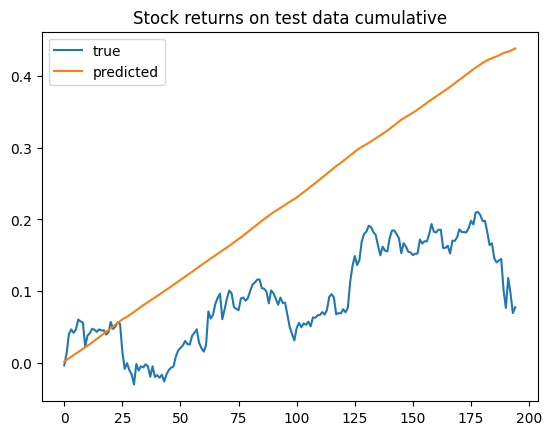

In [93]:
plot_prediction(trainer, model, datamodule, type="test")